In [3]:
%matplotlib inline
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
data_path = "data/clean raw data.xlsx"
df = pd.read_excel(data_path)

In [5]:
X = df[df.columns[3:]]
Y = df["Brix"].values

In [6]:
X_matrix = X.to_numpy()
nonzero_index = np.nonzero(X_matrix.sum(axis = 0))[0]
X_matrix_nonzero = X_matrix[:, nonzero_index]
X_nonzero_columns = X.columns[nonzero_index]

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_matrix_nonzero, Y, test_size = 0.2)

In [8]:
accuracy_list = []
for i in tqdm(range(1, X_train.shape[1])):
    pls2 = PLSRegression(n_components=i)
    pls2.fit(X_train, Y_train)
    Y_pred = pls2.predict(X_test)
    score = r2_score(Y_pred, Y_test)
    accuracy_list.append(score)

100%|██████████| 207/207 [00:06<00:00, 33.29it/s]


In [9]:
import pickle
def save_pickle(stuff, f):
    pickle_out = open(f,"wb")
    pickle.dump(stuff, pickle_out)
    pickle_out.close()
    
stuff = accuracy_list
f = "pickles/accuracy_list.pk1"
save_pickle(stuff, f)

In [10]:
save_pickle((X_train, X_test, Y_train, Y_test), "pickles/XYtraintest.pk1")

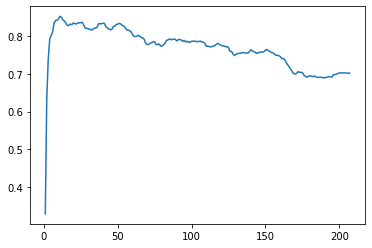

In [11]:
plt.plot(range(1, X_train.shape[1]), accuracy_list)
plt.show()

In [12]:
class environment():
    def __init__(self, xy, cur_pos, mapp, grid, idol_range, idol_steps, detect_range, step_options=range(-10, 11)):
        # argument never change
        self.mapp = mapp # map
        self.grid = grid # all place where the climber could move
        self.idol_range = idol_range # if the last idol_steps did not change the accuracy more than idol_range,
                                    # the policy is done
        self.idol_steps = idol_steps
        self.X_train, self.X_test, self.Y_train, self.Y_test = xy
        self.step_options = step_options
        self.detect_range = detect_range
        
        # argument that will change
        self.cur_pos = cur_pos # current position
        self.st_history = [] # short term history of previous movement
        self.known_place_dict = {0: 0} # record the accuracy got from every detection and movement
        
        
    def calAccuracy(self, x):
        pls2 = PLSRegression(n_components=x)
        pls2.fit(self.X_train, self.Y_train)
        Y_pred = pls2.predict(self.X_test)
        y = r2_score(Y_pred, self.Y_test)
        return y
    
    def observe(self, x, action):
        looking_forward = True
        if len(self.st_history) > 1 and self.step_options[np.argmax(action)] < 0: # keep the inertia of the last movement
            looking_forward = False
            
        observation_ = []
        
        if looking_forward:
            x_list = x + np.array(self.detect_range)
        else:
            x_list = x - np.array(self.detect_range)
        for tmp_x in x_list:
            if tmp_x not in self.known_place_dict.keys():
                if tmp_x < 0:
                    observation_.append(0)
                else:
                    observation_.append(self.calAccuracy(tmp_x))
                self.known_place_dict[tmp_x] = observation_[-1]
            else:
                observation_.append(self.known_place_dict[tmp_x])
                
        return np.array(observation_)
        
    
    def step(self, action):
        '''
        Return observation_, reward, done
        '''
        x = self.cur_pos[0]
        if (x == self.grid[-1] and x > 0)\
                            or (x == self.grid[0] and x < 0):
            observation_ = np.zeros(len(detect_range))
            return observation_, self.cur_pos[1], True
        
        x += action
        if x > self.grid[-1]:
            x = self.grid[-1]
        elif x < self.grid[0]:
            x = self.grid[0]
        
        y = self.calAccuracy(x)
        self.cur_pos = (x, y)
        
        if x not in self.known_place_dict.keys():
            self.known_place_dict[x] = y
        
        observation_ = self.observe(x, action)
                
        reward = y
        
        if len(self.st_history) < self.idol_steps:
            self.st_history.append(y)
        else:
            self.st_history.pop(0)
            self.st_history.append(y)
            
        done = False
        if len(self.st_history) >= idol_steps:
            if max(self.st_history) - min(self.st_history) < self.idol_range:
                done = True
        
        return observation_, reward, done
        
    def reset(self, pos=None):
        if pos is None:
            x = np.random.choice(self.grid)
        else:
            x = pos
        self.cur_pos = (x, self.calAccuracy(x))
        self.st_history = []
        observation_ = self.observe(x, 0)
        return observation_
        
        
    
    def showCurPos(self):
        plt.plot(*self.mapp, color="y")
        plt.scatter(*self.cur_pos, color="b")
        plt.show()
        
        
idol_range = 0
idol_steps = 2
detect_range = list(range(-1, 2))
detect_range.remove(0)
step_options = range(-2, 3)
xy = (X_train, X_test, Y_train, Y_test)
sample_com = 100        
pls2 = PLSRegression(n_components=sample_com)
pls2.fit(X_train, Y_train)
Y_pred = pls2.predict(X_test)
score = r2_score(Y_pred, Y_test)
cur_pos = (sample_com, score)
mapp = (range(1, X_train.shape[1]), accuracy_list)
grid = range(1, X_train.shape[1])
env = environment(xy, cur_pos, mapp, grid, idol_range, idol_steps, detect_range, step_options)

In [13]:
env.calAccuracy(150)

0.762521816454854

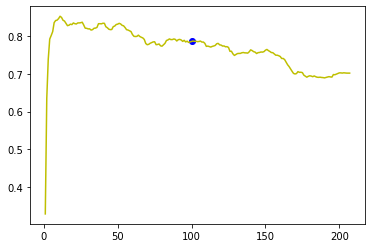

(100, 0.7856810834942254)
[0.7856810834942254] 0 2 False


In [14]:
action = 0
# env.reset(20)
observation_, reward, done = env.step(action)
env.showCurPos()
print(env.cur_pos)
print(env.st_history, env.idol_range, env.idol_steps, done)

In [15]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size  
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape)) # input_shape is the number of state
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros((self.mem_size))
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        """
        :param state: old state
        :param action: action in the transition
        :param reward: rewards gain from old state to new state
        :param state_: new state
        :param done: signal for stop moving
        :return: None

        save old state in self.state_memory
        save new state in self.new_state_memory
        save action in self.action_memory
        save reward in self.reward_memory
        save done in terminal memory
        """
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions to action memory, if appropriate
        if self.discrete:
            actions = np.zeros((self.action_memory.shape[1]))
            actions[action] = 1
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        """
        :param batch_size: size of batch
        :return: old states, actions, rewards, new states, terminal
        sample some transitions from memory
        """
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal


def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    """
    :param lr: Learning rate
    :param n_actions: number of possible actions
    :param input_dims: input dimension
    :param fc1_dims: dimension of first layer fully connected hidden layer
    :param fc2_dims: dimension of second layer fully connected hiden layer
    :return: A neural network model for deep Q learning
    """
    model = Sequential([
        Dense(fc1_dims, input_shape=(input_dims,)),
        Activation('relu'),
        Dense(fc2_dims),
        Activation('relu'),
        Dense(n_actions)
    ])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

In [16]:
class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996, epsilon_end=0.01,
                 mem_size=1000000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
    
    
    def remember(self, state, action, reward, new_state, done):
        """
        :param state: old state
        :param action: action in the transition
        :param reward: rewards gain from old state to new state
        :param state_: new state
        :param done: signal for stop moving
        :return: None

        Remember decision and store into memories
        """
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        """
        :return: None
        Learn from the last step
        """
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)
            q_eval = self.q_eval.predict(state)  # find the current Q value

            q_next = self.q_eval.predict(new_state)  # find the future Q values at the next state

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + self.gamma * np.max(q_next, axis=1) * done
            # change the current Q matrix by reward of the transition plus the max future reward

            _ = self.q_eval.fit(state, q_target, verbose=0)  # fit model

            self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > \
                                                              self.epsilon_min else self.epsilon_min
            # reduce epsilon

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model_(self):
        self.q_eval = load_model(self.model_file)


In [17]:
%matplotlib inline
lr = 0.05
n_games = 100
agent = Agent(gamma=0.02, epsilon=0.0, alpha=lr, input_dims=len(detect_range),
              n_actions=len(step_options), mem_size=1000000, batch_size=64, epsilon_end=0.0)

# agent.load_model_()
scores = []
eps_history = []

all_history = collections.defaultdict(dict)
action_history_list = []

for i in tqdm(range(n_games)):
    done = False
    score = 0
    observation = env.reset(40)
    counter = 0
    while not done and counter <=100:
#         env.showCurPos()
        if i == 0:
            action = np.random.choice(step_options)
        else:
            action = agent.choose_action(observation)
        action_history_list.append(action)
#         if counter == 0:    
#             print(agent.q_eval.predict(observation.reshape((1, 2))))
        observation_, reward, done = env.step(action)
        score += reward
        agent.remember(observation, action, reward, observation_, int(done))
        observation = observation_

#         print(agent.q_eval.predict(observation))
        
        agent.learn()
        
        all_history[i][counter] = env.cur_pos
        
        counter += 1
        
        scores.append(score)

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:12<06:52,  4.25s/it]

KeyboardInterrupt: 

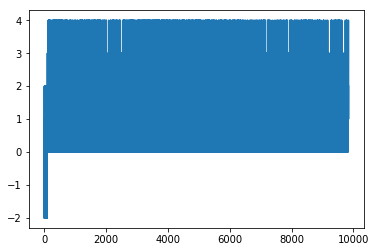

In [96]:
plt.plot(action_history_list)

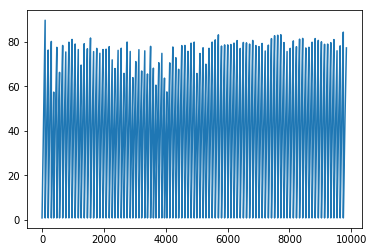

In [97]:
plt.plot(scores)

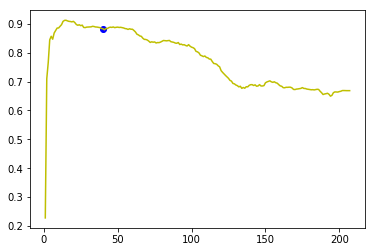

2 (40, 0.8828529372218837)


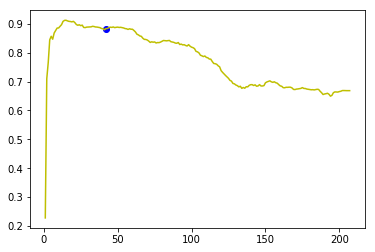

4 (42, 0.8835030463144075)


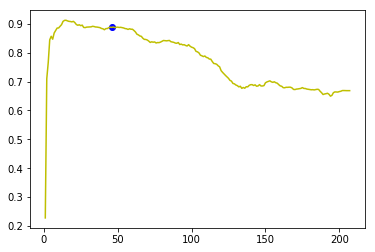

4 (46, 0.8876215153640254)


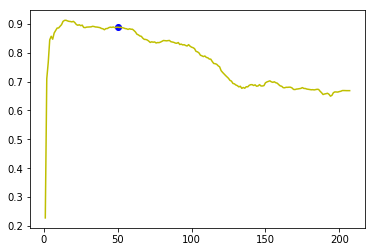

0 (50, 0.8885363582433297)


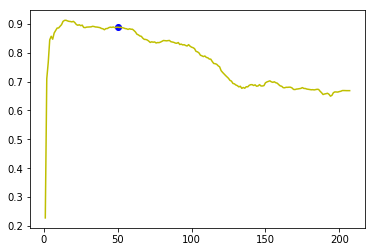

0 (50, 0.8885363582433297)


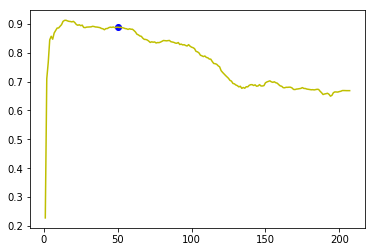

1 (50, 0.8885363582433297)


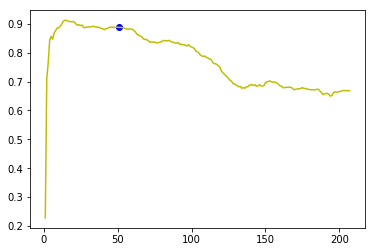

1 (51, 0.8874806286019732)


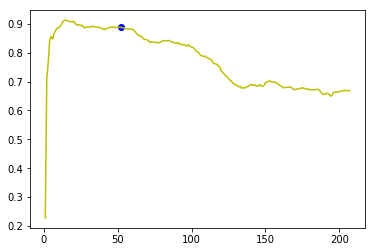

0 (52, 0.8879338002412557)


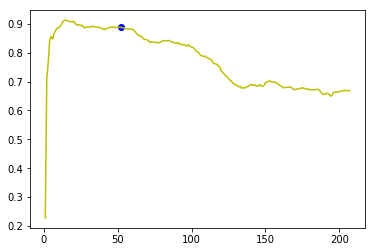

0 (52, 0.8879338002412557)


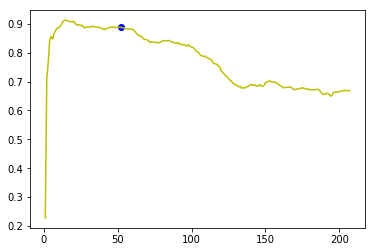

0 (52, 0.8879338002412557)


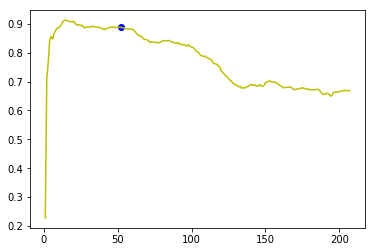

0 (52, 0.8879338002412557)


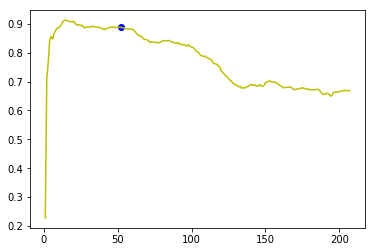

1 (52, 0.8879338002412557)


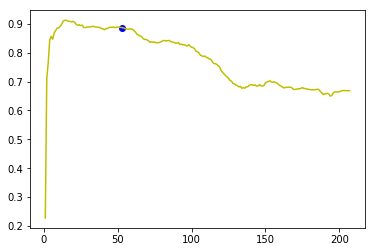

1 (53, 0.8869739156690796)


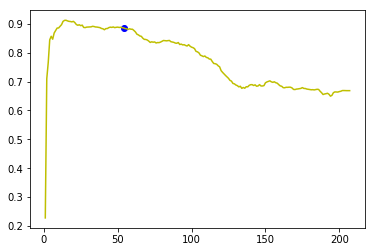

1 (54, 0.8857155363400785)


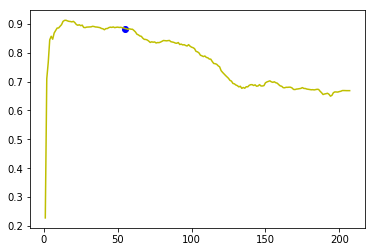

3 (55, 0.8835426626434969)


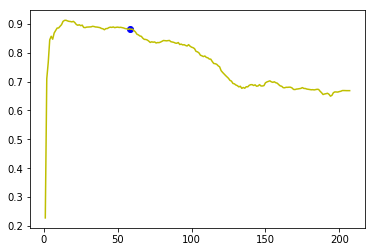

3 (58, 0.8828588785751169)


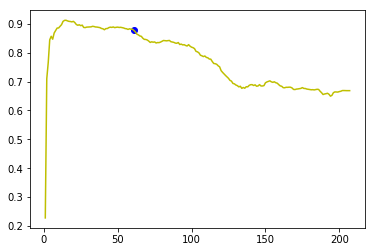

4 (61, 0.8768905867783682)


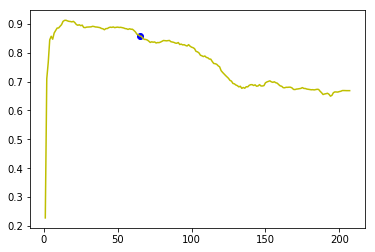

0 (65, 0.858012409250338)


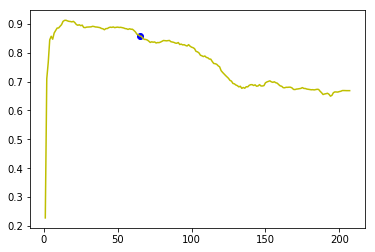

0 (65, 0.858012409250338)


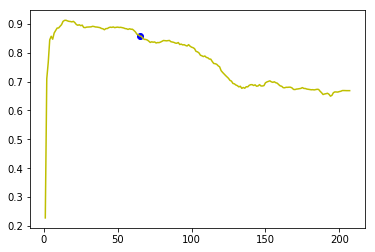

0 (65, 0.858012409250338)


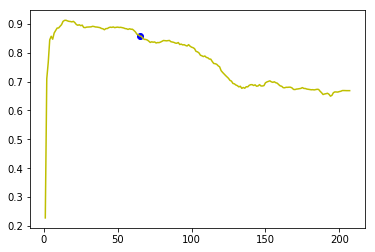

0 (65, 0.858012409250338)


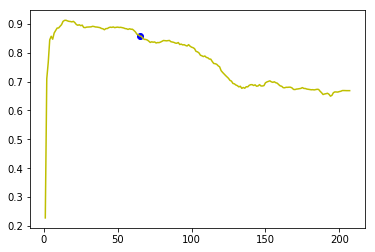

2 (65, 0.858012409250338)


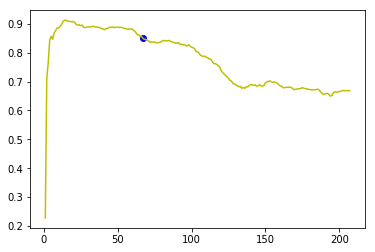

0 (67, 0.8502516249504699)


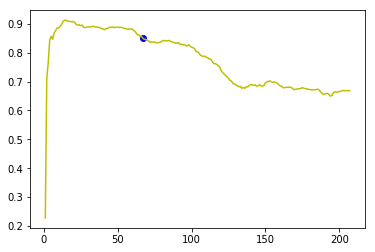

0 (67, 0.8502516249504699)


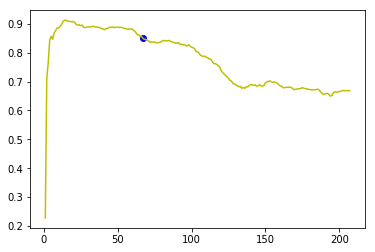

0 (67, 0.8502516249504699)


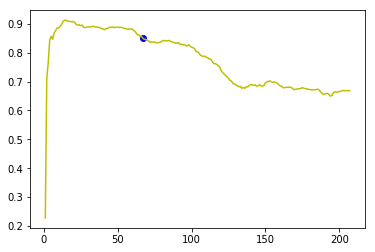

1 (67, 0.8502516249504699)


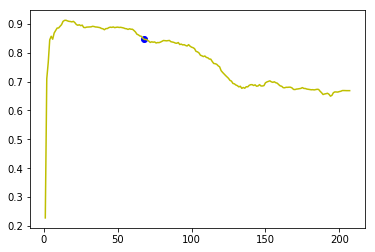

1 (68, 0.8461560913058916)


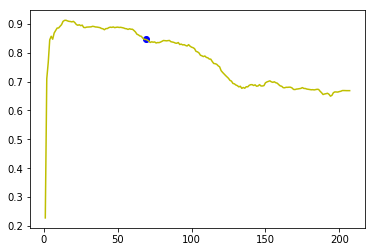

1 (69, 0.845852376572174)


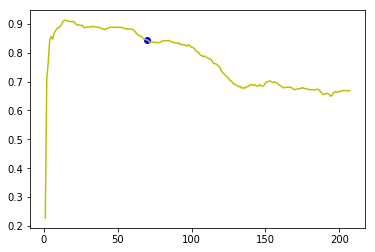

0 (70, 0.8439725371080713)


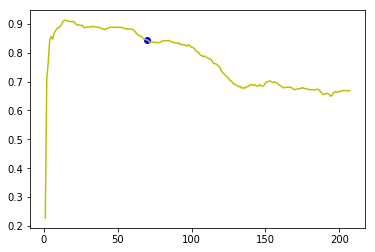

1 (70, 0.8439725371080713)


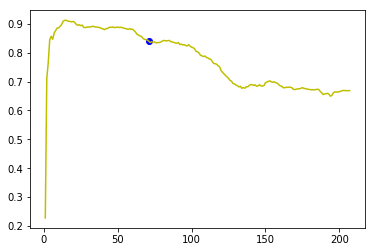

1 (71, 0.8403015761681334)


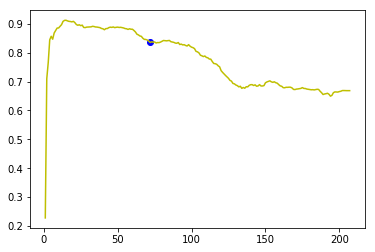

1 (72, 0.8355528878672086)


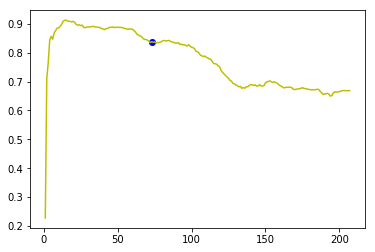

1 (73, 0.8377221152467939)


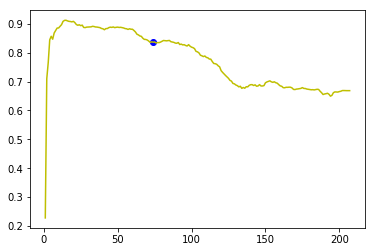

1 (74, 0.8363692689395854)


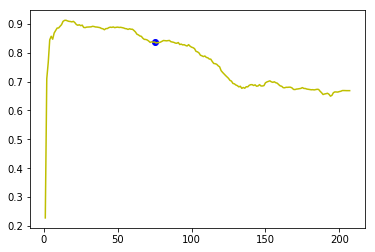

2 (75, 0.8373254820568948)


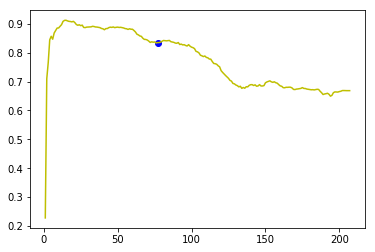

0 (77, 0.8351416724585824)


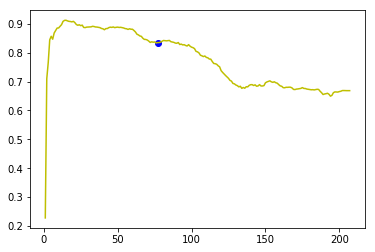

0 (77, 0.8351416724585824)


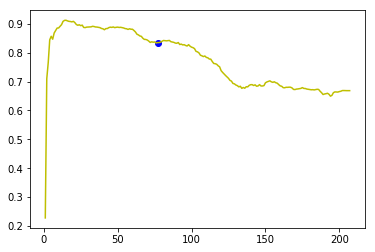

3 (77, 0.8351416724585824)


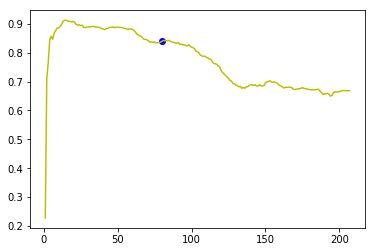

3 (80, 0.8394455824834166)


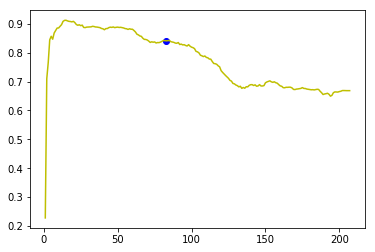

3 (83, 0.8410816209659923)


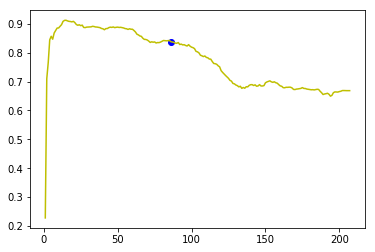

3 (86, 0.8381303523407783)


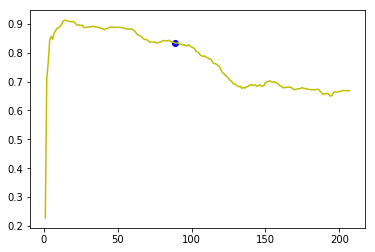

3 (89, 0.8333499106854361)


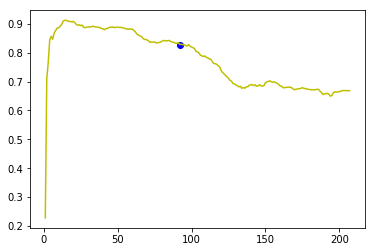

3 (92, 0.8283498770906933)


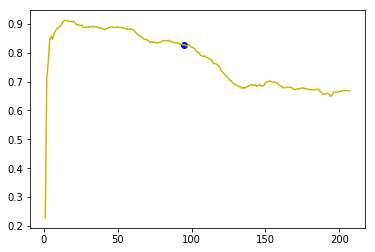

0 (95, 0.8276551547921998)


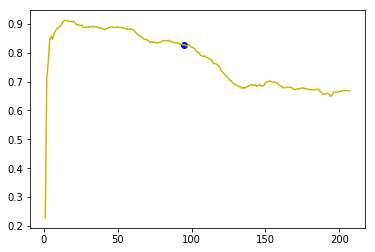

0 (95, 0.8276551547921998)


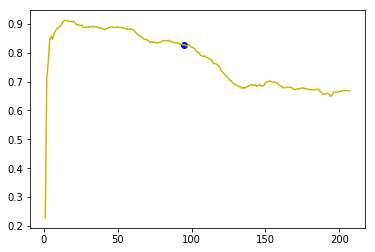

4 (95, 0.8276551547921998)


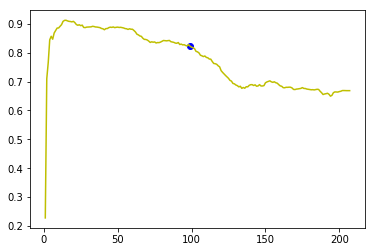

4 (99, 0.822496738352952)


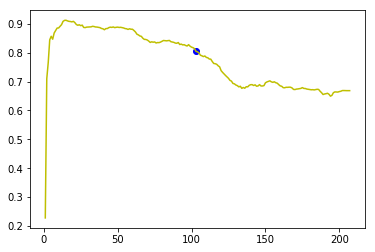

3 (103, 0.8047463342590824)


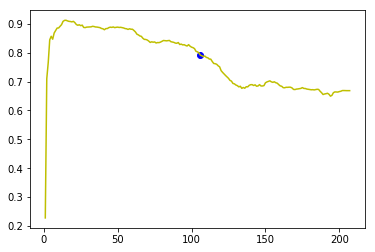

3 (106, 0.7912992131518257)


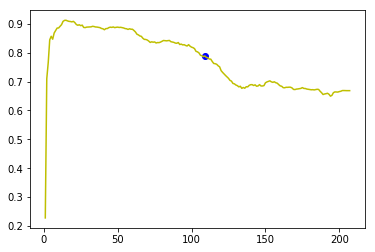

0 (109, 0.7885720105648971)


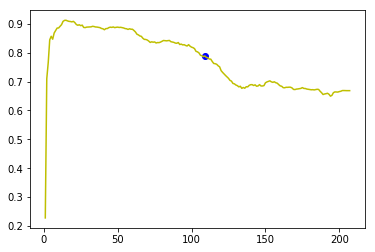

0 (109, 0.7885720105648971)


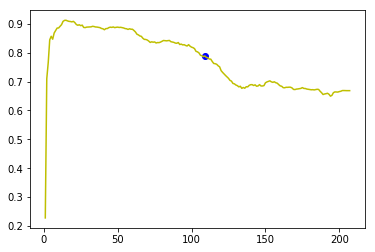

0 (109, 0.7885720105648971)


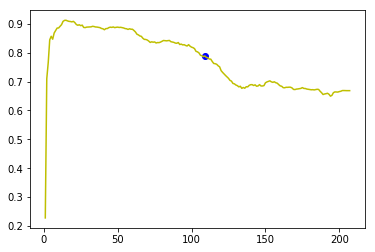

0 (109, 0.7885720105648971)


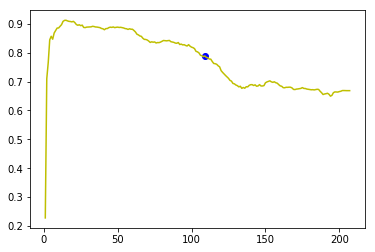

4 (109, 0.7885720105648971)


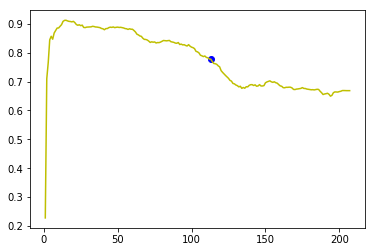

4 (113, 0.7776702120850942)


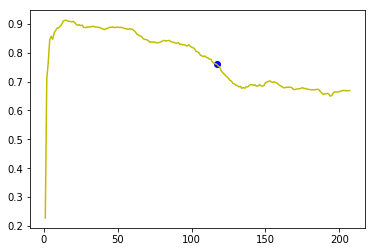

1 (117, 0.7599084755191954)


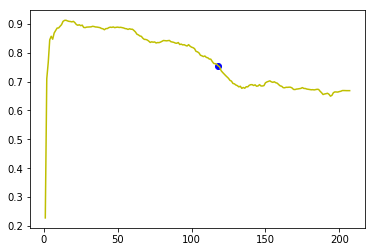

1 (118, 0.7546009223734008)


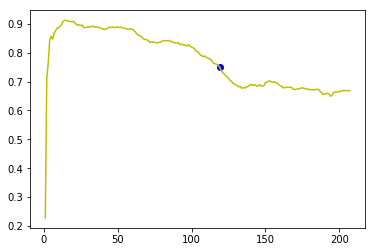

0 (119, 0.7509880417812671)


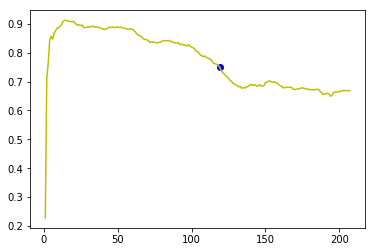

0 (119, 0.7509880417812671)


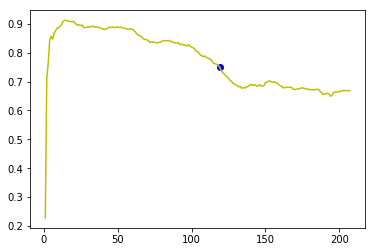

1 (119, 0.7509880417812671)


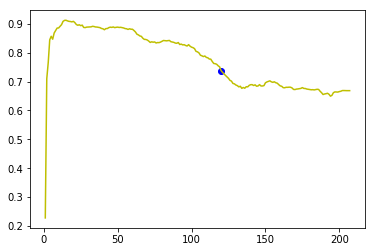

1 (120, 0.7378735052280722)


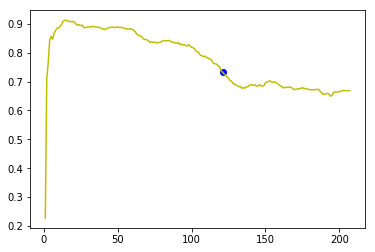

2 (121, 0.7317731326153518)


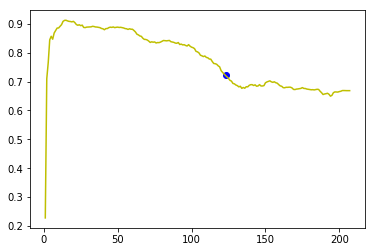

2 (123, 0.7210843561441231)


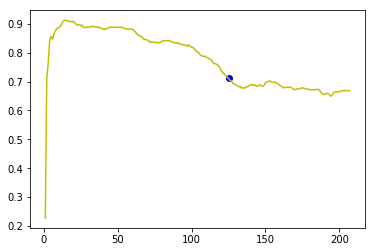

2 (125, 0.71117186047038)


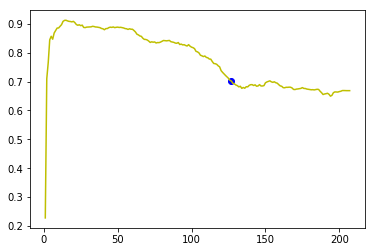

2 (127, 0.7016214676021866)


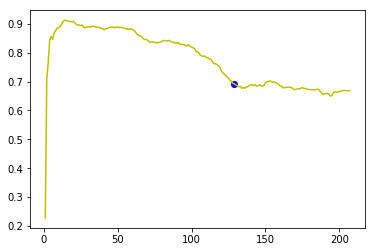

2 (129, 0.6920875844043259)


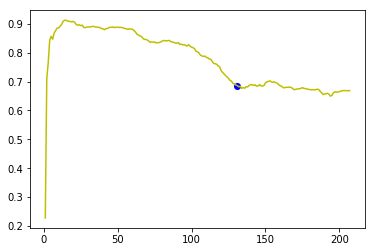

2 (131, 0.6859025814608642)


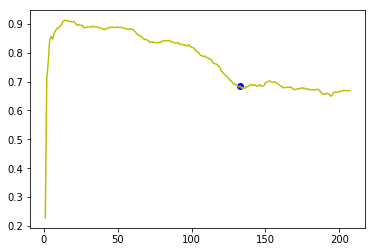

0 (133, 0.6837686011216074)


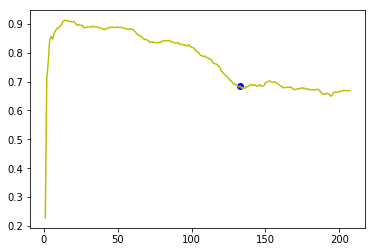

0 (133, 0.6837686011216074)


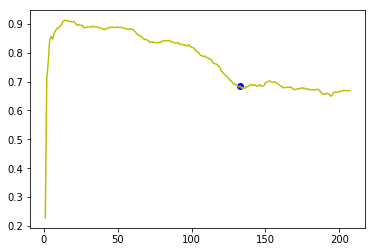

0 (133, 0.6837686011216074)


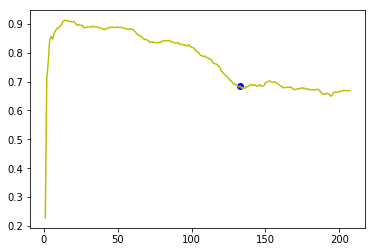

0 (133, 0.6837686011216074)


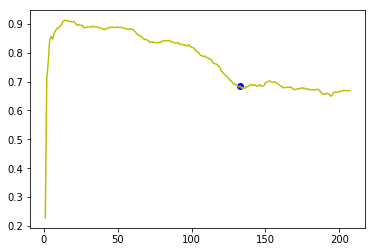

1 (133, 0.6837686011216074)


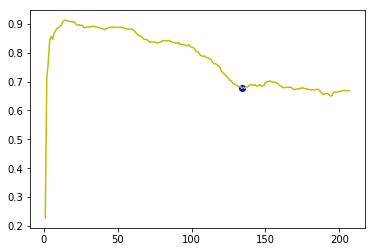

1 (134, 0.6765487358113891)


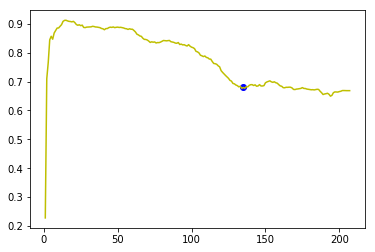

1 (135, 0.6796117074031147)


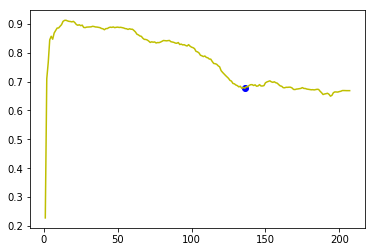

1 (136, 0.6769606070243022)


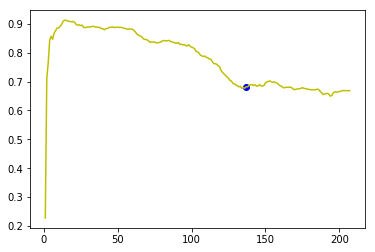

2 (137, 0.6821902071295406)


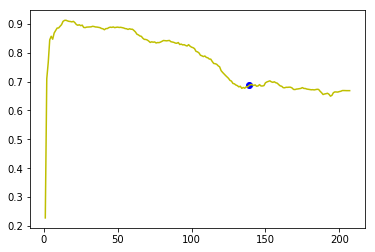

2 (139, 0.6868801732901688)


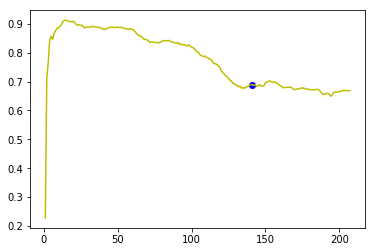

2 (141, 0.6894058186261407)


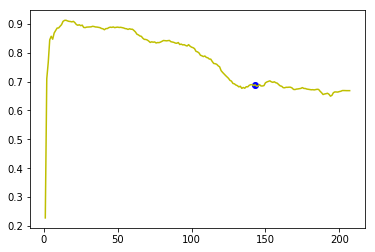

2 (143, 0.6887181424958491)


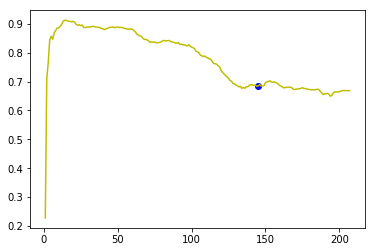

4 (145, 0.6848851801894356)


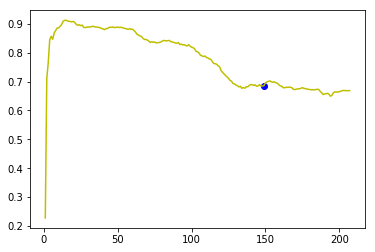

4 (149, 0.6860403146405751)


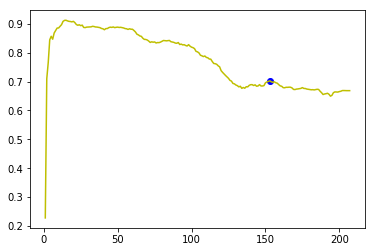

2 (153, 0.7025775670192848)


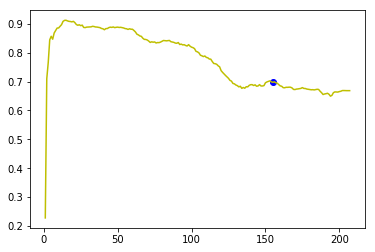

1 (155, 0.6974119845565996)


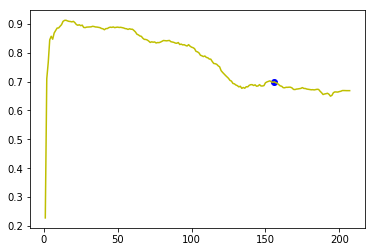

1 (156, 0.6992718803466935)


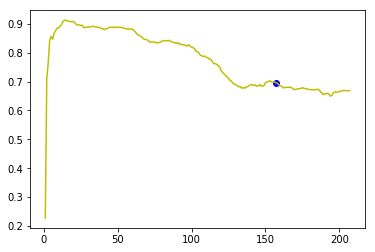

0 (157, 0.695995660004604)


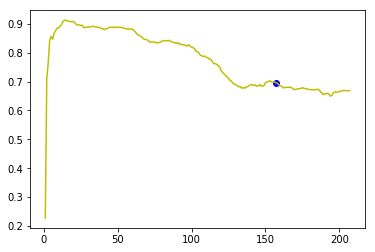

0 (157, 0.695995660004604)


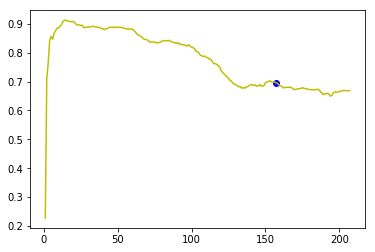

4 (157, 0.695995660004604)


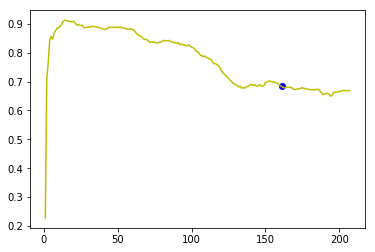

1 (161, 0.6837699919379896)


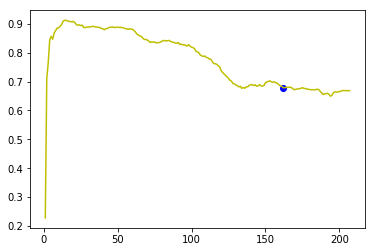

1 (162, 0.6790247422119191)


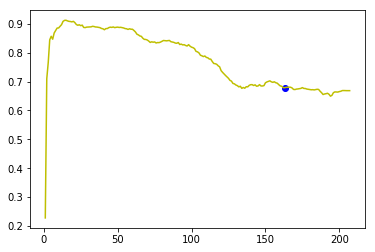

1 (163, 0.678533280039075)


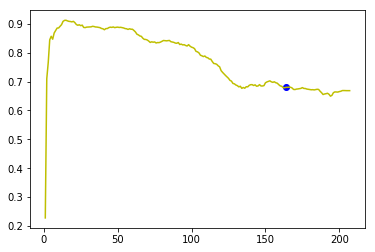

0 (164, 0.680192589037111)


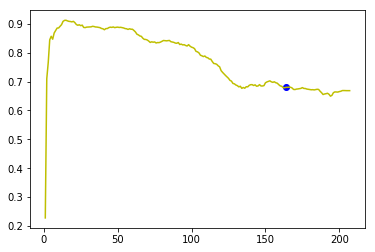

0 (164, 0.680192589037111)


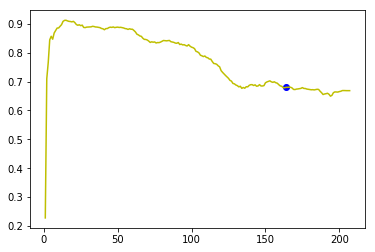

0 (164, 0.680192589037111)


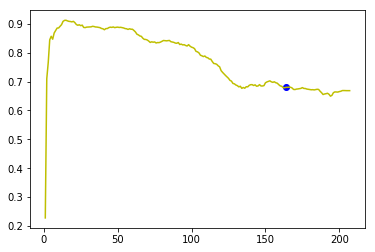

2 (164, 0.680192589037111)


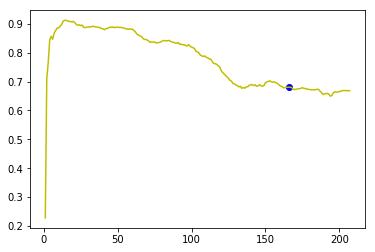

2 (166, 0.6806898337345102)


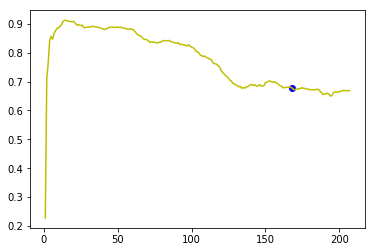

2 (168, 0.6779877814836668)


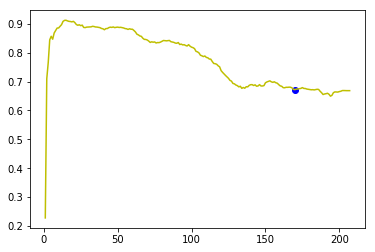

0 (170, 0.6723715760443794)


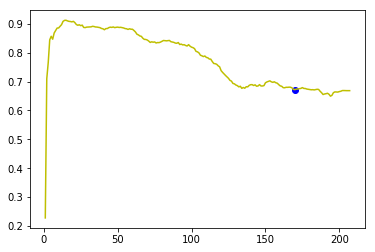

0 (170, 0.6723715760443794)


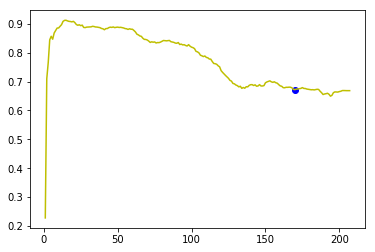

1 (170, 0.6723715760443794)


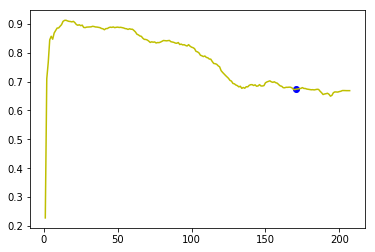

1 (171, 0.6740119255159798)


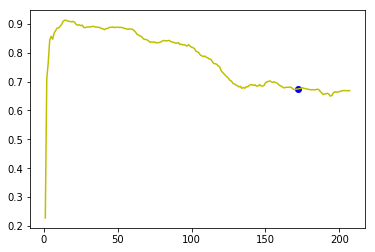

1 (172, 0.6744747004190741)


In [98]:
done = False
score = 0
observation = env.reset(40)
counter = 0
while not done and counter <=100:
    env.showCurPos()
    if i == 0:
        action = np.random.choice(step_options)
    else:
        action = agent.choose_action(observation)
    action_history_list.append(action)
#         if counter == 0:    
#             print(agent.q_eval.predict(observation.reshape((1, 2))))
    print(action, env.cur_pos)
    observation_, reward, done = env.step(action)
    score += reward
    agent.remember(observation, action, reward, observation_, int(done))
    observation = observation_

#         print(agent.q_eval.predict(observation))

    agent.learn()

    all_history[i][counter] = env.cur_pos

    counter += 1

    scores.append(score)

In [ ]:
def update_plot(game_n, movement, all_history):
    ax.clear()
    print(all_history[game_n][movement])
    ax.plot(*mapp, color = "y")
    ax.scatter(*all_history[game_n][movement], color = "b")
    plt.show()

fig, ax = plt.subplots(1)
plt.suptitle("Climber Movement")

game_n = widgets.IntSlider(min=0, max=n_games, value=0, step=1, description="Games:")
movement = widgets.IntSlider(min=0, max=20, value=0, step=1, description="Movement:")


widgets.interactive(update_plot, game_n=game_n, movement=movement, all_history=all_history)

display(game_n, movement)

In [ ]:
def update_plot(amp, phase, freq):
    ax.clear()
    y = amp * np.sin(2*np.pi * (freq * x + phase))
    
    ax.plot(x, y)
    plt.show()

x = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(1)
plt.suptitle("Sine Wave")

amp = widgets.FloatLogSlider(min=1, max=10, value=4, description="Amp:")
phase = widgets.FloatLogSlider(min=0, max=5, value=0, description="Phase:")
freq = widgets.FloatSlider(min=1, max=10, value=1, description="Freq:")

widgets.interactive(update_plot, amp=amp, phase=phase, freq=freq)

display(amp, phase, freq)

In [ ]:
fig, ax = plt.subplots(1)
plt.suptitle("Sine Wave")
for point in [(1, 2), (3, 4), (5, 6)]:
    ax.clear()
    ax.scatter(*point)
    plt.show()
